### Machine Learning with Big Data
## Part 1: Fully Connected Layers

# 0.3 - experiments mlp

**Group:** MLBD_Deventer 4
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

## Setup and speed
enable xla mixed precision and gpu memory growth

In [1]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'
import json, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

tf.config.optimizer.set_jit(True)
try: tf.config.experimental.enable_tensor_float_32_execution(True)
except: pass
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except: pass


2025-10-26 17:43:18.547447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-26 17:43:18.596232: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 Laptop GPU, compute capability 8.9


2025-10-26 17:43:19.437500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 17:43:19.451908: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 17:43:19.453757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 17:43:19.455192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Load meta and data
use balanced train data and raw validation data

In [2]:
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)
num_classes = len(meta['label_classes'])

x_train_path = '../artifacts/X_train_balanced.npy' if os.path.exists('../artifacts/X_train_balanced.npy') else '../artifacts/X_train.npy'
y_train_path = '../artifacts/y_train_balanced.npy' if os.path.exists('../artifacts/y_train_balanced.npy') else '../artifacts/y_train.npy'

X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_val   = np.load('../artifacts/X_val.npy')
y_val   = np.load('../artifacts/y_val.npy')

y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val,   num_classes)


## Make tf datasets
cast to float16 and build input pipeline

In [3]:
X_train = X_train.astype('float16', copy=False)
X_val   = X_val.astype('float16', copy=False)

BATCH = 1024
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh)).cache().shuffle(10000).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_oh)).cache().batch(BATCH).prefetch(tf.data.AUTOTUNE)

os.makedirs('../artifacts/experiments', exist_ok=True)


2025-10-26 17:43:19.572910: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-26 17:43:19.573955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 17:43:19.575210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-26 17:43:19.576200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had 

# Define experiment configs
relu tanh sigmoid with and without dropout with different sizes

In [4]:
configs = [
    # relu no dropout
    {'name':'relu_1x64_do0',      'layers':[64],                  'act':'relu',    'dropout':0.0},
    {'name':'relu_2x128_do0',     'layers':[128,128],             'act':'relu',    'dropout':0.0},
    {'name':'relu_3x256_do0',     'layers':[256,256,256],         'act':'relu',    'dropout':0.0},

    # relu with dropout
    {'name':'relu_1x128_do02',    'layers':[128],                 'act':'relu',    'dropout':0.2},
    {'name':'relu_2x256_do02',    'layers':[256,256],             'act':'relu',    'dropout':0.2},
    {'name':'relu_3x256_do03',    'layers':[256,256,256],         'act':'relu',    'dropout':0.3},

    # tanh no dropout
    {'name':'tanh_1x128_do0',     'layers':[128],                 'act':'tanh',    'dropout':0.0},
    {'name':'tanh_2x128_do0',     'layers':[128,128],             'act':'tanh',    'dropout':0.0},

    # tanh with dropout
    {'name':'tanh_1x256_do02',    'layers':[256],                 'act':'tanh',    'dropout':0.2},
    {'name':'tanh_2x256_do02',    'layers':[256,256],             'act':'tanh',    'dropout':0.2},

    # sigmoid no dropout
    {'name':'sigmoid_1x128_do0',  'layers':[128],                 'act':'sigmoid', 'dropout':0.0},
    {'name':'sigmoid_2x128_do0',  'layers':[128,128],             'act':'sigmoid', 'dropout':0.0},

    # sigmoid with dropout
    {'name':'sigmoid_1x256_do02', 'layers':[256],                 'act':'sigmoid', 'dropout':0.2},
    {'name':'sigmoid_2x256_do03', 'layers':[256,256],             'act':'sigmoid', 'dropout':0.3},
]


## Model builder
this function builds a simple neural network based on the settings you give it

1. **input layer**
   takes in one hand of cards as a list of numbers (the one hot encoded suits and ranks)

2. **hidden layers**
   for each number in the `layers` list
   it adds a dense (fully connected) layer with that many neurons
   it uses the activation function you picked (relu tanh or sigmoid)
   if dropout is higher than 0
   it adds a dropout layer to randomly turn off some neurons while training
   this helps to stop overfitting

3. **output layer**
   adds the final dense layer with one neuron per class
   uses softmax so the outputs add up to 1 and can be read as probabilities

4. **compile**
   uses the adam optimizer
   uses categorical crossentropy loss since this is a classification task
   measures how often it is correct with accuracy

5. **return**
   gives back the ready to train model








In [5]:
def build_model(input_dim, cfg, num_classes):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for u in cfg['layers']:
        x = keras.layers.Dense(u, activation=cfg['act'])(x)
        if cfg['dropout'] > 0.0:
            x = keras.layers.Dropout(cfg['dropout'])(x)
    out = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    m = keras.Model(inp, out)
    opt = keras.optimizers.legacy.Adam()
    m.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return m


# Run experiments
train each config save plots reports collect histories and confusion matrices

[1/14] relu_1x64_do0
Epoch 1/30


2025-10-26 17:43:20.136564: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f1880004390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-26 17:43:20.136597: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-26 17:43:20.141691: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 1/20 [>.............................] - ETA: 11s - loss: 2.3489 - accuracy: 0.0771

2025-10-26 17:43:20.368851: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-26 17:43:20.401667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 1s 26ms/step - loss: 2.2343 - accuracy: 0.1938 - val_loss: 2.3198 - val_accuracy: 0.0771
Epoch 2/30
20/20 [==============================] - 1s 27ms/step - loss: 2.0248 - accuracy: 0.3561 - val_loss: 2.2294 - val_accuracy: 0.1186
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 1.8338 - accuracy: 0.4525 - val_loss: 2.1216 - val_accuracy: 0.1699
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 1.6555 - accuracy: 0.5045 - val_loss: 2.0150 - val_accuracy: 0.2096
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 1.4971 - accuracy: 0.5437 - val_loss: 1.9065 - val_accuracy: 0.2459
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 1.3616 - accuracy: 0.5764 - val_loss: 1.8129 - val_accuracy: 0.2793
Epoch 7/30
20/20 [==============================] - 0s 8ms/step - loss: 1.2486 - accuracy: 0.6091 - val_loss: 1.7145 - val_accuracy: 0.3178
Epoch 8/30
20/20 [===========

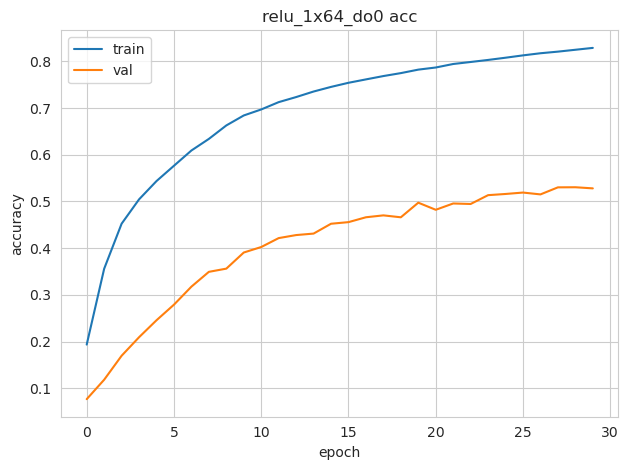

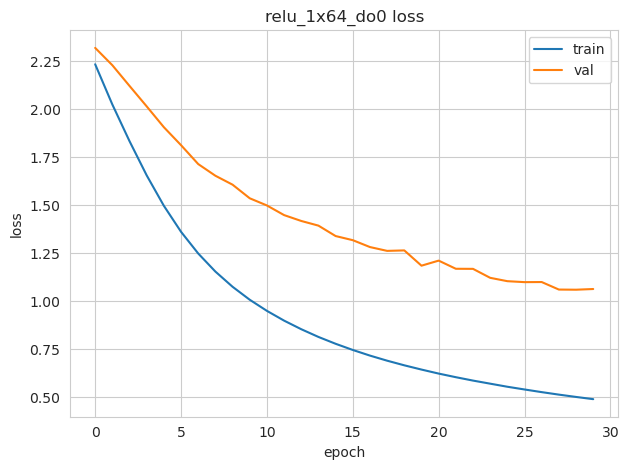

2025-10-26 17:43:26.706781: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


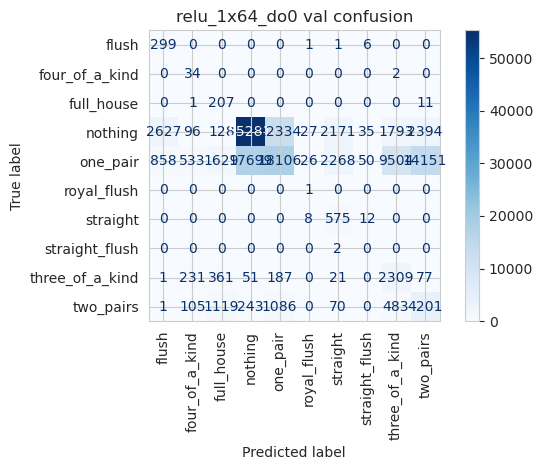

[2/14] relu_2x128_do0
Epoch 1/30
20/20 [==============================] - 1s 25ms/step - loss: 2.1250 - accuracy: 0.3354 - val_loss: 2.2027 - val_accuracy: 0.1292
Epoch 2/30
20/20 [==============================] - 1s 31ms/step - loss: 1.6529 - accuracy: 0.4966 - val_loss: 1.8739 - val_accuracy: 0.2458
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 1.2081 - accuracy: 0.5961 - val_loss: 1.6172 - val_accuracy: 0.3012
Epoch 4/30
20/20 [==============================] - 0s 10ms/step - loss: 0.9328 - accuracy: 0.6889 - val_loss: 1.4249 - val_accuracy: 0.4140
Epoch 5/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7635 - accuracy: 0.7408 - val_loss: 1.3302 - val_accuracy: 0.4437
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 0.6412 - accuracy: 0.7776 - val_loss: 1.1692 - val_accuracy: 0.5069
Epoch 7/30
20/20 [==============================] - 0s 11ms/step - loss: 0.5521 - accuracy: 0.8038 - val_loss: 1.0864 - val_accuracy: 

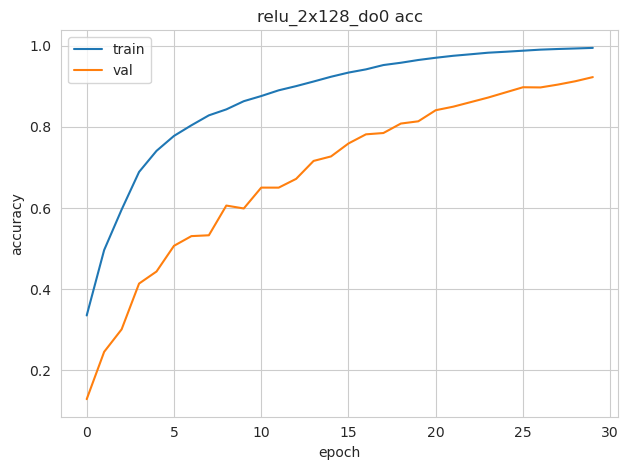

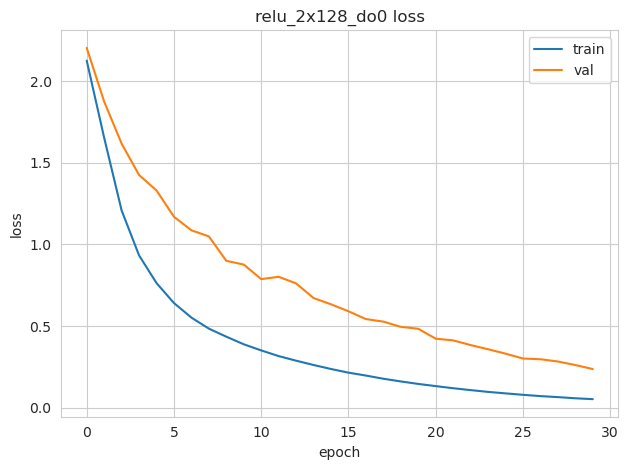

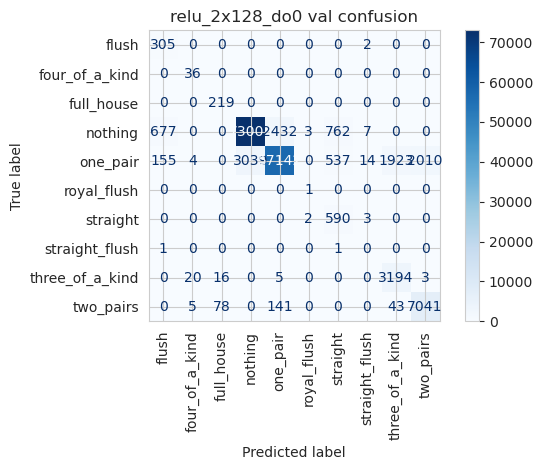

[3/14] relu_3x256_do0
Epoch 1/30
20/20 [==============================] - 1s 25ms/step - loss: 1.8547 - accuracy: 0.4530 - val_loss: 1.7060 - val_accuracy: 0.3196
Epoch 2/30
20/20 [==============================] - 1s 37ms/step - loss: 0.9696 - accuracy: 0.6618 - val_loss: 1.2733 - val_accuracy: 0.4630
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 0.6036 - accuracy: 0.7804 - val_loss: 1.1039 - val_accuracy: 0.5031
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 0.4457 - accuracy: 0.8293 - val_loss: 0.9454 - val_accuracy: 0.5563
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 0.3460 - accuracy: 0.8683 - val_loss: 0.8096 - val_accuracy: 0.6365
Epoch 6/30
20/20 [==============================] - 0s 10ms/step - loss: 0.2608 - accuracy: 0.9067 - val_loss: 0.6082 - val_accuracy: 0.7367
Epoch 7/30
20/20 [==============================] - 0s 9ms/step - loss: 0.2028 - accuracy: 0.9313 - val_loss: 0.5003 - val_accuracy: 0.

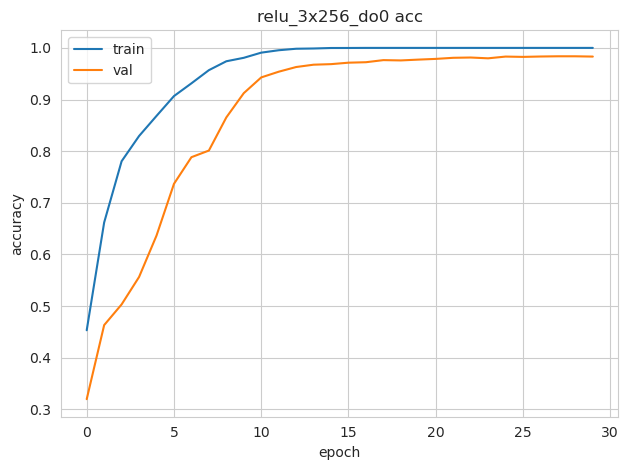

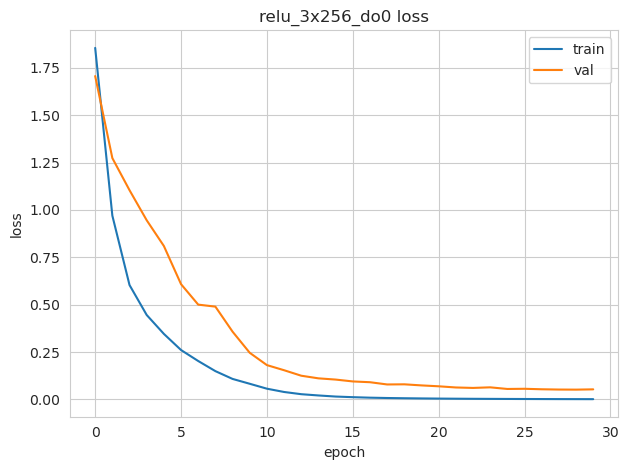

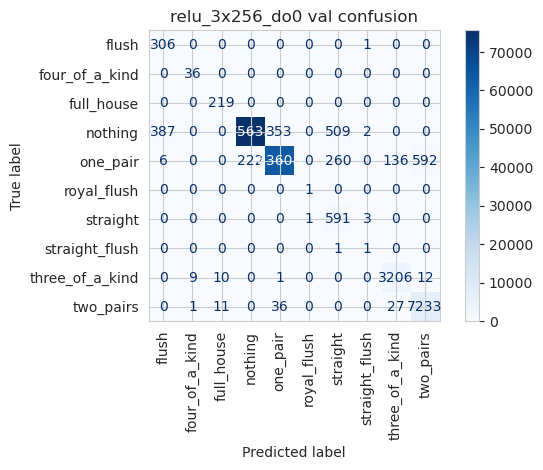

[4/14] relu_1x128_do02
Epoch 1/30
20/20 [==============================] - 1s 20ms/step - loss: 2.1866 - accuracy: 0.2297 - val_loss: 2.2232 - val_accuracy: 0.1453
Epoch 2/30
20/20 [==============================] - 1s 28ms/step - loss: 1.9140 - accuracy: 0.4163 - val_loss: 2.1024 - val_accuracy: 0.2110
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 1.6692 - accuracy: 0.4940 - val_loss: 1.9391 - val_accuracy: 0.2820
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 1.4495 - accuracy: 0.5497 - val_loss: 1.8239 - val_accuracy: 0.2859
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 1.2797 - accuracy: 0.5925 - val_loss: 1.6936 - val_accuracy: 0.3406
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 1.1505 - accuracy: 0.6345 - val_loss: 1.5955 - val_accuracy: 0.3808
Epoch 7/30
20/20 [==============================] - 0s 8ms/step - loss: 1.0522 - accuracy: 0.6617 - val_loss: 1.5349 - val_accuracy: 0.

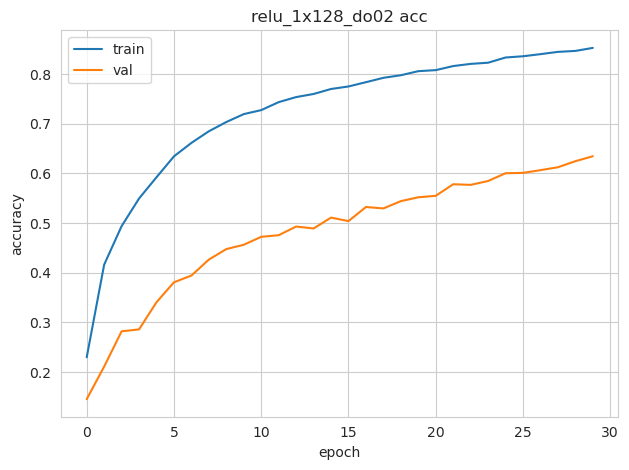

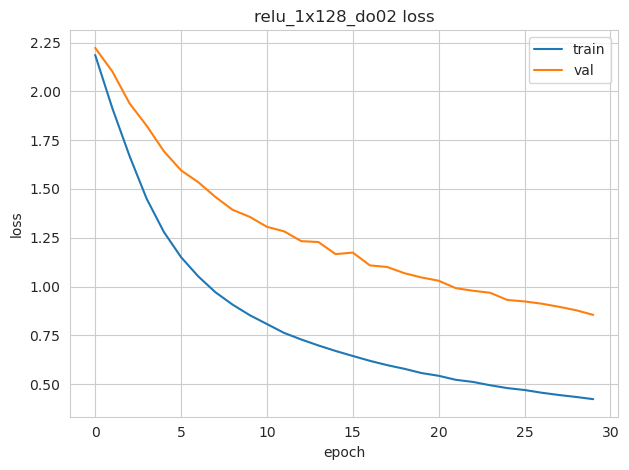

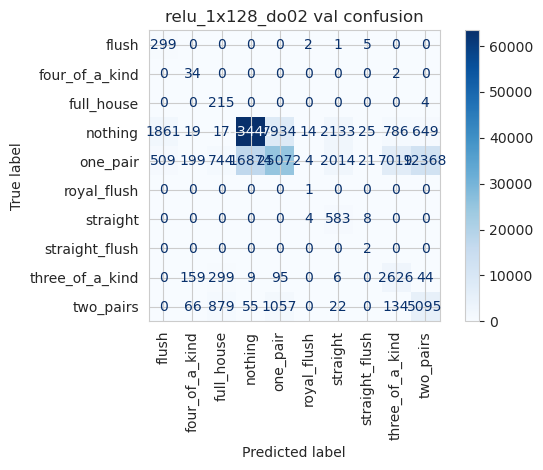

[5/14] relu_2x256_do02
Epoch 1/30
20/20 [==============================] - 1s 23ms/step - loss: 1.9907 - accuracy: 0.3672 - val_loss: 2.0360 - val_accuracy: 0.1543
Epoch 2/30
20/20 [==============================] - 1s 34ms/step - loss: 1.3284 - accuracy: 0.5538 - val_loss: 1.5899 - val_accuracy: 0.3649
Epoch 3/30
20/20 [==============================] - 0s 10ms/step - loss: 0.9559 - accuracy: 0.6621 - val_loss: 1.3979 - val_accuracy: 0.4271
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 0.7537 - accuracy: 0.7287 - val_loss: 1.1243 - val_accuracy: 0.5261
Epoch 5/30
20/20 [==============================] - 0s 12ms/step - loss: 0.6305 - accuracy: 0.7695 - val_loss: 1.0220 - val_accuracy: 0.5651
Epoch 6/30
20/20 [==============================] - 0s 9ms/step - loss: 0.5507 - accuracy: 0.7921 - val_loss: 0.9609 - val_accuracy: 0.5786
Epoch 7/30
20/20 [==============================] - 0s 11ms/step - loss: 0.4841 - accuracy: 0.8200 - val_loss: 0.8982 - val_accuracy:

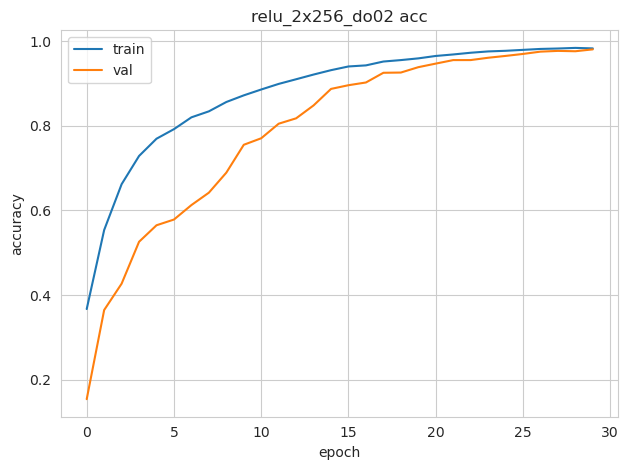

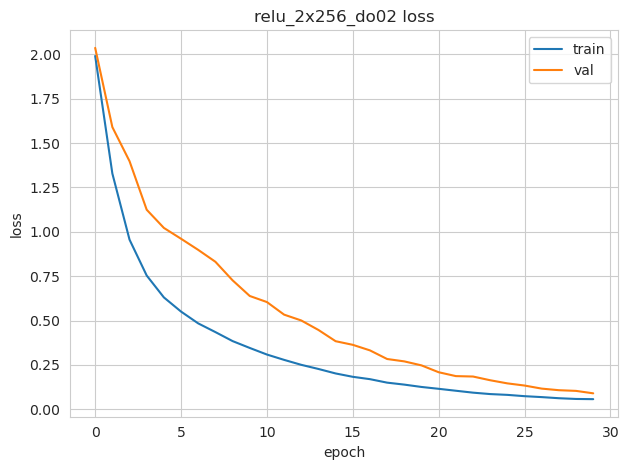

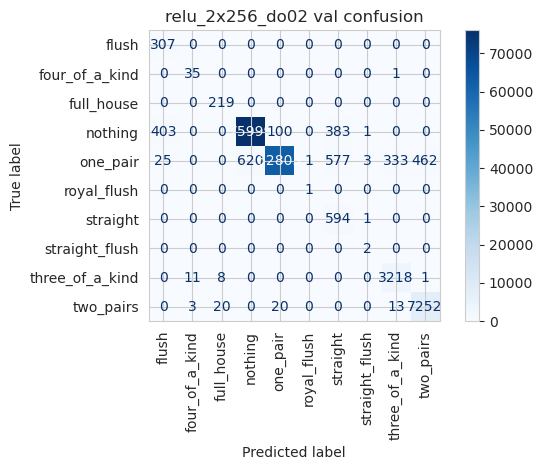

[6/14] relu_3x256_do03
Epoch 1/30
20/20 [==============================] - 1s 22ms/step - loss: 2.0035 - accuracy: 0.3120 - val_loss: 1.9010 - val_accuracy: 0.3159
Epoch 2/30
20/20 [==============================] - 1s 34ms/step - loss: 1.3461 - accuracy: 0.5049 - val_loss: 1.3839 - val_accuracy: 0.4657
Epoch 3/30
20/20 [==============================] - 0s 10ms/step - loss: 0.9673 - accuracy: 0.6370 - val_loss: 1.2358 - val_accuracy: 0.4974
Epoch 4/30
20/20 [==============================] - 0s 10ms/step - loss: 0.7559 - accuracy: 0.7124 - val_loss: 1.1021 - val_accuracy: 0.5142
Epoch 5/30
20/20 [==============================] - 0s 10ms/step - loss: 0.6319 - accuracy: 0.7574 - val_loss: 1.0144 - val_accuracy: 0.5419
Epoch 6/30
20/20 [==============================] - 0s 10ms/step - loss: 0.5464 - accuracy: 0.7873 - val_loss: 0.8698 - val_accuracy: 0.6300
Epoch 7/30
20/20 [==============================] - 0s 12ms/step - loss: 0.4762 - accuracy: 0.8108 - val_loss: 0.7867 - val_accurac

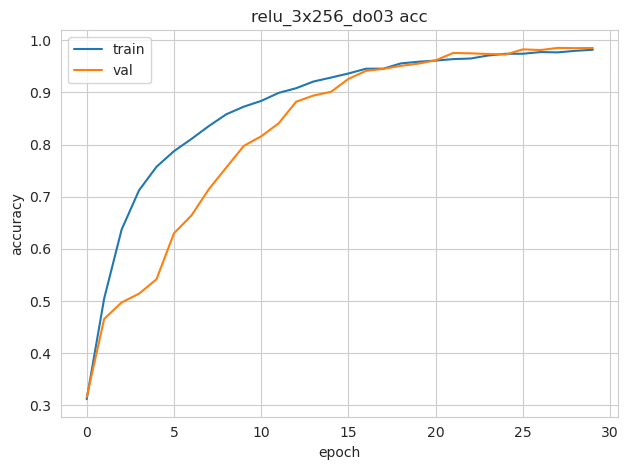

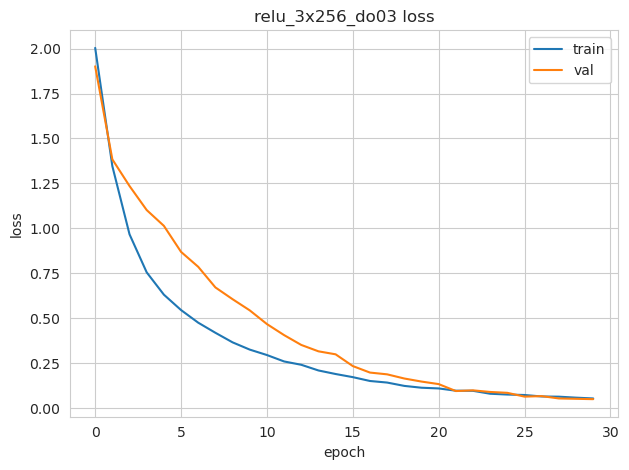

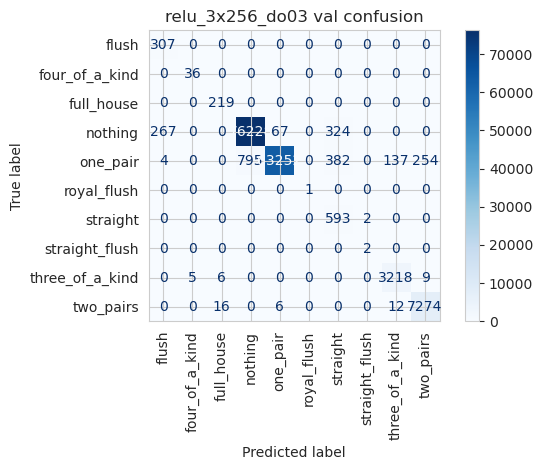

[7/14] tanh_1x128_do0
Epoch 1/30
20/20 [==============================] - 1s 20ms/step - loss: 2.1287 - accuracy: 0.2446 - val_loss: 2.2048 - val_accuracy: 0.1411
Epoch 2/30
20/20 [==============================] - 1s 27ms/step - loss: 1.7782 - accuracy: 0.4317 - val_loss: 2.0339 - val_accuracy: 0.1653
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 1.5583 - accuracy: 0.4997 - val_loss: 1.8889 - val_accuracy: 0.1905
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 1.4084 - accuracy: 0.5397 - val_loss: 1.7957 - val_accuracy: 0.1951
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 1.3045 - accuracy: 0.5528 - val_loss: 1.7444 - val_accuracy: 0.2162
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 1.2303 - accuracy: 0.5649 - val_loss: 1.6821 - val_accuracy: 0.2381
Epoch 7/30
20/20 [==============================] - 0s 8ms/step - loss: 1.1764 - accuracy: 0.5714 - val_loss: 1.6639 - val_accuracy: 0.2

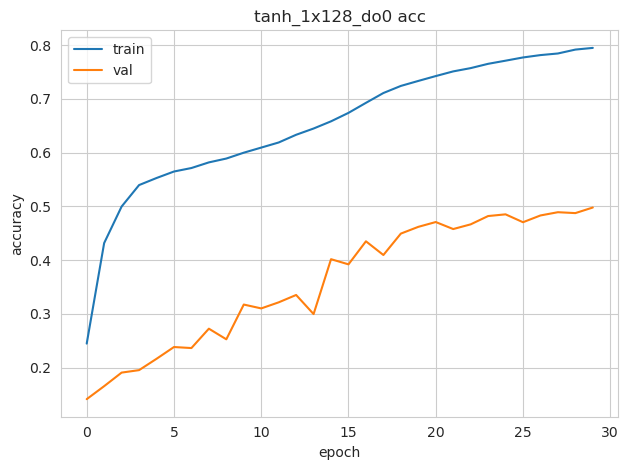

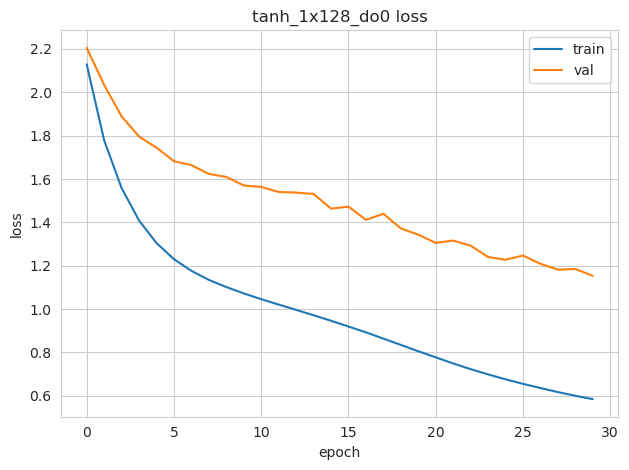

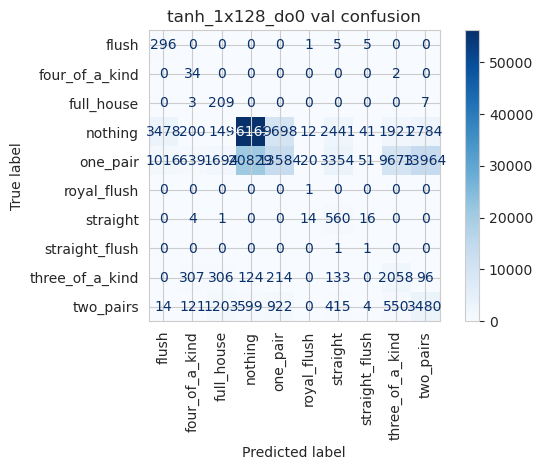

[8/14] tanh_2x128_do0
Epoch 1/30
20/20 [==============================] - 1s 21ms/step - loss: 1.9757 - accuracy: 0.3114 - val_loss: 2.0147 - val_accuracy: 0.2085
Epoch 2/30
20/20 [==============================] - 1s 44ms/step - loss: 1.4723 - accuracy: 0.5050 - val_loss: 1.8089 - val_accuracy: 0.2285
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 1.2427 - accuracy: 0.5570 - val_loss: 1.7155 - val_accuracy: 0.2451
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 1.1250 - accuracy: 0.5834 - val_loss: 1.5882 - val_accuracy: 0.3404
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 1.0516 - accuracy: 0.6105 - val_loss: 1.5566 - val_accuracy: 0.3208
Epoch 6/30
20/20 [==============================] - 0s 9ms/step - loss: 0.9917 - accuracy: 0.6402 - val_loss: 1.4506 - val_accuracy: 0.4017
Epoch 7/30
20/20 [==============================] - 0s 8ms/step - loss: 0.9285 - accuracy: 0.6748 - val_loss: 1.3933 - val_accuracy: 0.4

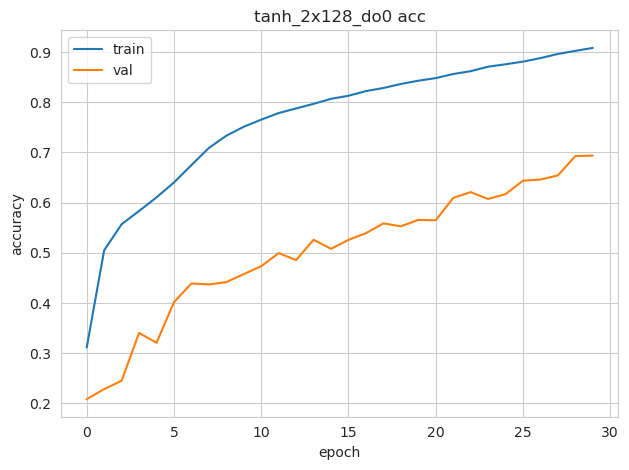

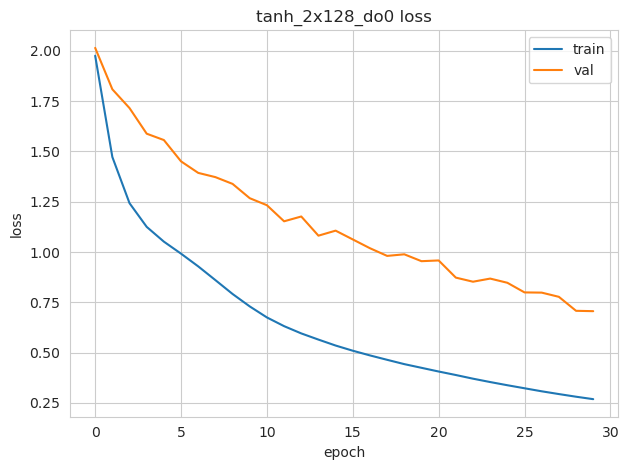

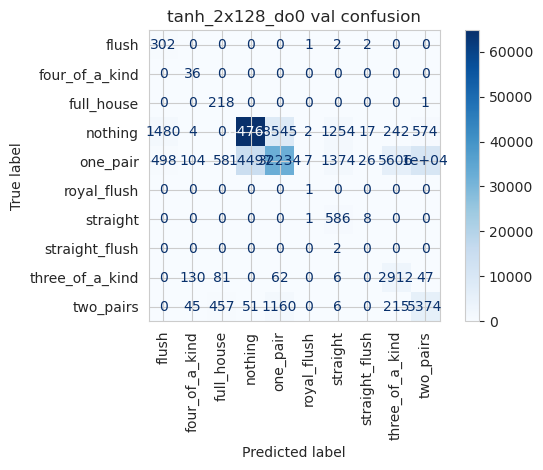

[9/14] tanh_1x256_do02
Epoch 1/30
20/20 [==============================] - 1s 20ms/step - loss: 2.0477 - accuracy: 0.2893 - val_loss: 2.1080 - val_accuracy: 0.1871
Epoch 2/30
20/20 [==============================] - 1s 31ms/step - loss: 1.6278 - accuracy: 0.4586 - val_loss: 1.8677 - val_accuracy: 0.2539
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 1.4111 - accuracy: 0.5152 - val_loss: 1.7686 - val_accuracy: 0.2359
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 1.2816 - accuracy: 0.5430 - val_loss: 1.6855 - val_accuracy: 0.2704
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 1.2028 - accuracy: 0.5581 - val_loss: 1.6422 - val_accuracy: 0.2688
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 1.1511 - accuracy: 0.5644 - val_loss: 1.6463 - val_accuracy: 0.2407
Epoch 7/30
20/20 [==============================] - 0s 8ms/step - loss: 1.1140 - accuracy: 0.5766 - val_loss: 1.5668 - val_accuracy: 0.

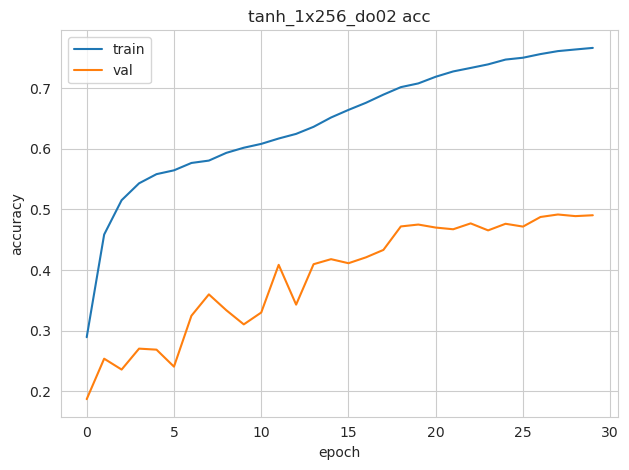

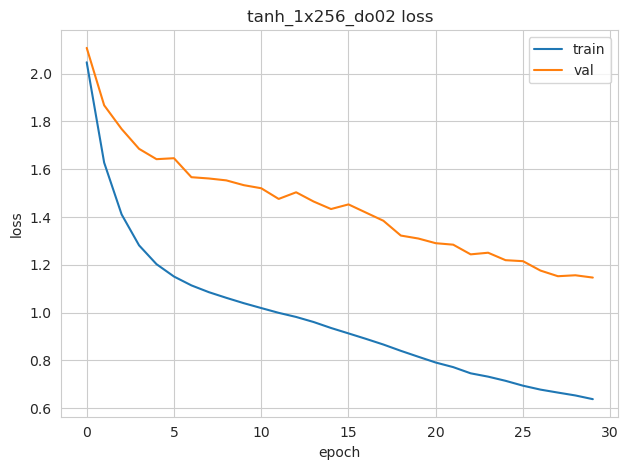

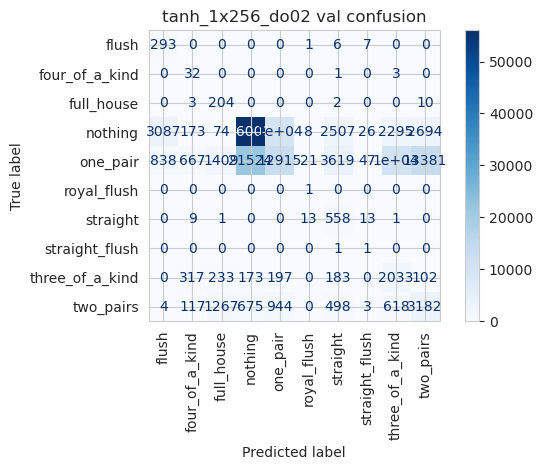

[10/14] tanh_2x256_do02
Epoch 1/30
20/20 [==============================] - 1s 22ms/step - loss: 1.8148 - accuracy: 0.3665 - val_loss: 1.7353 - val_accuracy: 0.3553
Epoch 2/30
20/20 [==============================] - 1s 36ms/step - loss: 1.3050 - accuracy: 0.5226 - val_loss: 1.6663 - val_accuracy: 0.2547
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 1.1590 - accuracy: 0.5598 - val_loss: 1.5980 - val_accuracy: 0.2553
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 1.1004 - accuracy: 0.5749 - val_loss: 1.5104 - val_accuracy: 0.3475
Epoch 5/30
20/20 [==============================] - 0s 9ms/step - loss: 1.0517 - accuracy: 0.5967 - val_loss: 1.5018 - val_accuracy: 0.3004
Epoch 6/30
20/20 [==============================] - 0s 9ms/step - loss: 1.0016 - accuracy: 0.6187 - val_loss: 1.4748 - val_accuracy: 0.3712
Epoch 7/30
20/20 [==============================] - 0s 9ms/step - loss: 0.9513 - accuracy: 0.6457 - val_loss: 1.3700 - val_accuracy: 0

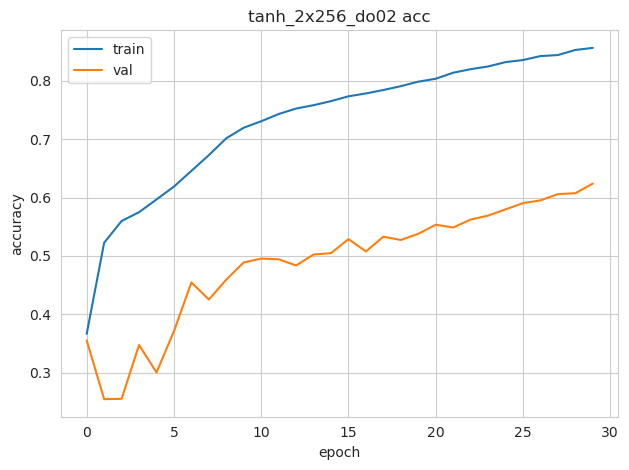

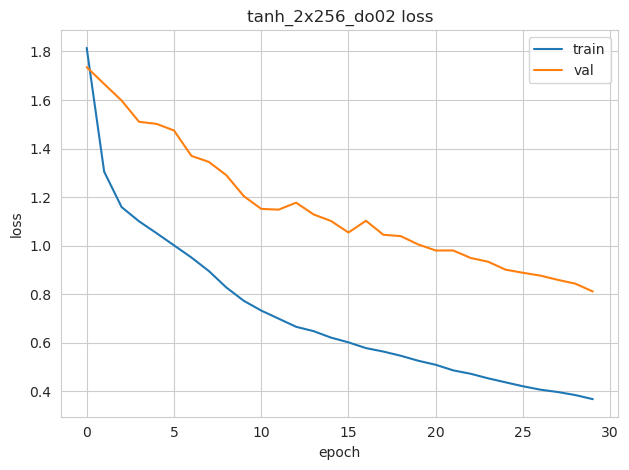

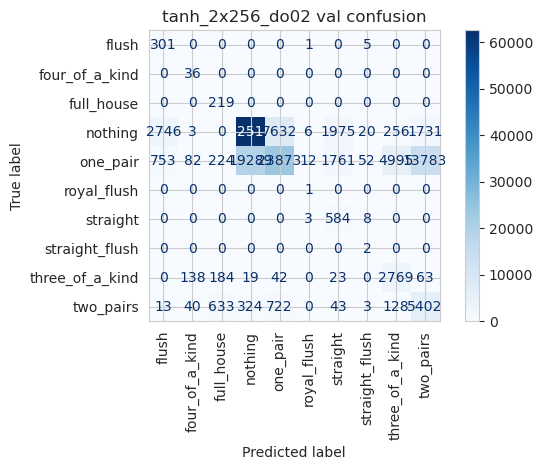

[11/14] sigmoid_1x128_do0
Epoch 1/30
20/20 [==============================] - 2s 45ms/step - loss: 2.3039 - accuracy: 0.1548 - val_loss: 2.2453 - val_accuracy: 0.1648
Epoch 2/30
20/20 [==============================] - 1s 32ms/step - loss: 2.1664 - accuracy: 0.3282 - val_loss: 2.2583 - val_accuracy: 0.1172
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 2.0639 - accuracy: 0.4283 - val_loss: 2.2195 - val_accuracy: 0.1838
Epoch 4/30
20/20 [==============================] - 0s 9ms/step - loss: 1.9685 - accuracy: 0.4462 - val_loss: 2.1779 - val_accuracy: 0.1583
Epoch 5/30
20/20 [==============================] - 0s 9ms/step - loss: 1.8765 - accuracy: 0.4676 - val_loss: 2.1167 - val_accuracy: 0.2304
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 1.7894 - accuracy: 0.4733 - val_loss: 2.0758 - val_accuracy: 0.1361
Epoch 7/30
20/20 [==============================] - 0s 8ms/step - loss: 1.7078 - accuracy: 0.4907 - val_loss: 2.0034 - val_accuracy:

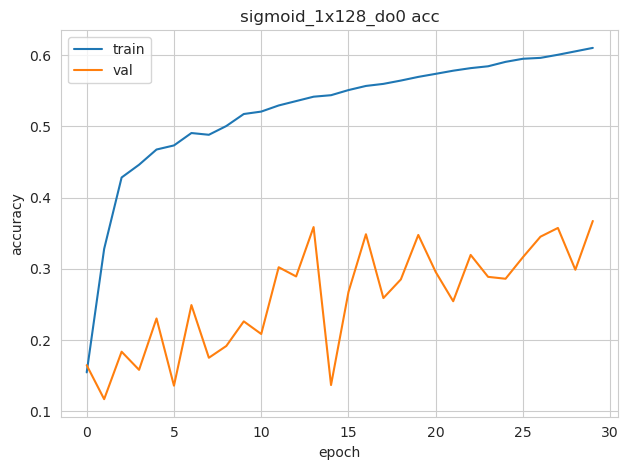

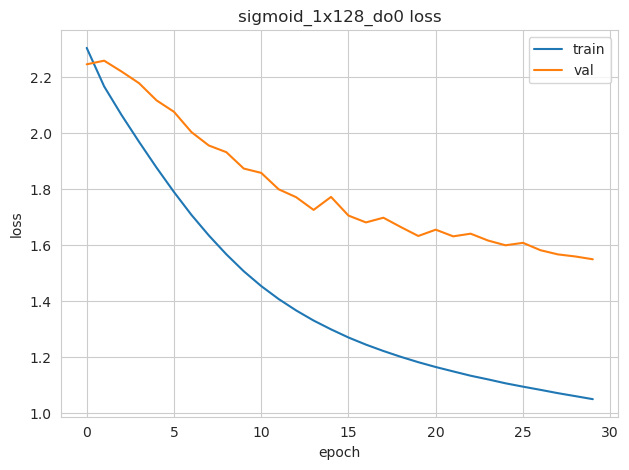

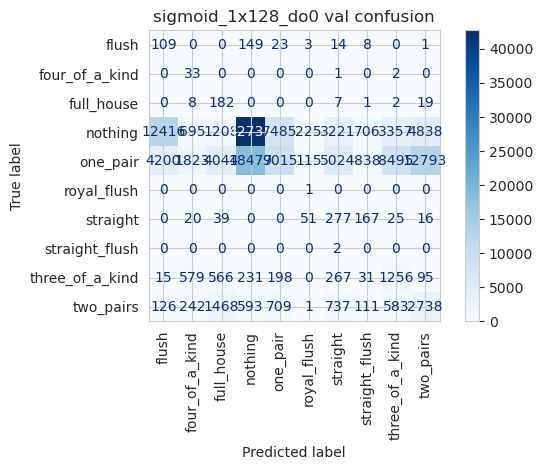

[12/14] sigmoid_2x128_do0
Epoch 1/30
20/20 [==============================] - 1s 20ms/step - loss: 2.3085 - accuracy: 0.1276 - val_loss: 2.3131 - val_accuracy: 0.0152
Epoch 2/30
20/20 [==============================] - 1s 30ms/step - loss: 2.2407 - accuracy: 0.2773 - val_loss: 2.3309 - val_accuracy: 0.0037
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 2.1636 - accuracy: 0.3175 - val_loss: 2.3757 - val_accuracy: 0.0199
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 2.0492 - accuracy: 0.3790 - val_loss: 2.2961 - val_accuracy: 0.0282
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 1.9313 - accuracy: 0.3955 - val_loss: 2.1939 - val_accuracy: 0.0489
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 1.8185 - accuracy: 0.4214 - val_loss: 2.0897 - val_accuracy: 0.2503
Epoch 7/30
20/20 [==============================] - 0s 8ms/step - loss: 1.7034 - accuracy: 0.4399 - val_loss: 1.9981 - val_accuracy:

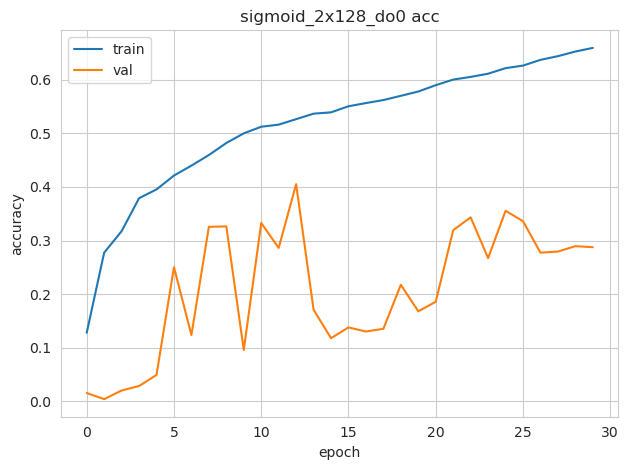

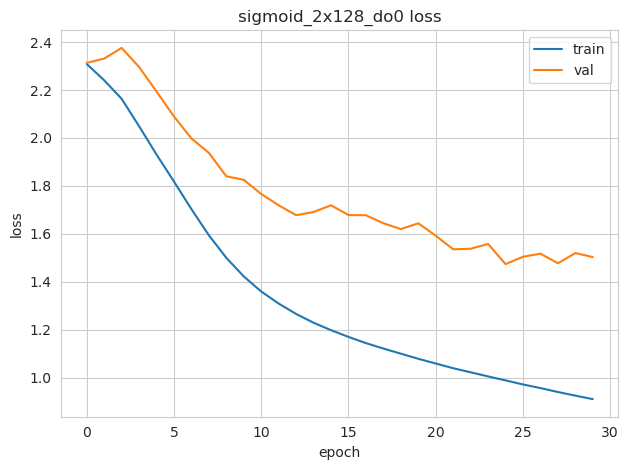

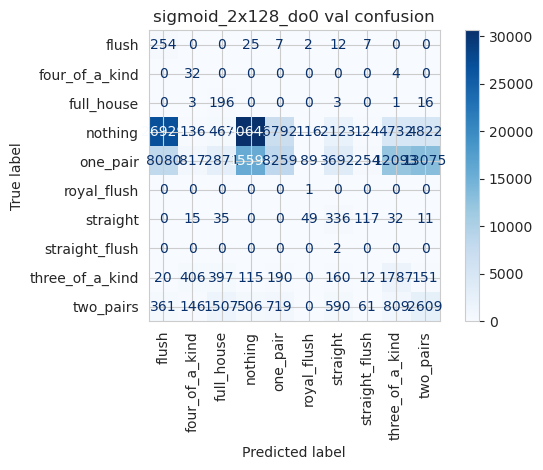

[13/14] sigmoid_1x256_do02
Epoch 1/30
20/20 [==============================] - 1s 20ms/step - loss: 2.3685 - accuracy: 0.1254 - val_loss: 2.2145 - val_accuracy: 0.2724
Epoch 2/30
20/20 [==============================] - 1s 30ms/step - loss: 2.1674 - accuracy: 0.2369 - val_loss: 2.2691 - val_accuracy: 0.0526
Epoch 3/30
20/20 [==============================] - 0s 8ms/step - loss: 2.0389 - accuracy: 0.3129 - val_loss: 2.1848 - val_accuracy: 0.1540
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 1.9213 - accuracy: 0.3615 - val_loss: 2.0830 - val_accuracy: 0.1367
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 1.8124 - accuracy: 0.3898 - val_loss: 2.0553 - val_accuracy: 0.0949
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 1.7218 - accuracy: 0.4170 - val_loss: 1.9648 - val_accuracy: 0.2242
Epoch 7/30
20/20 [==============================] - 0s 8ms/step - loss: 1.6420 - accuracy: 0.4384 - val_loss: 1.9278 - val_accuracy

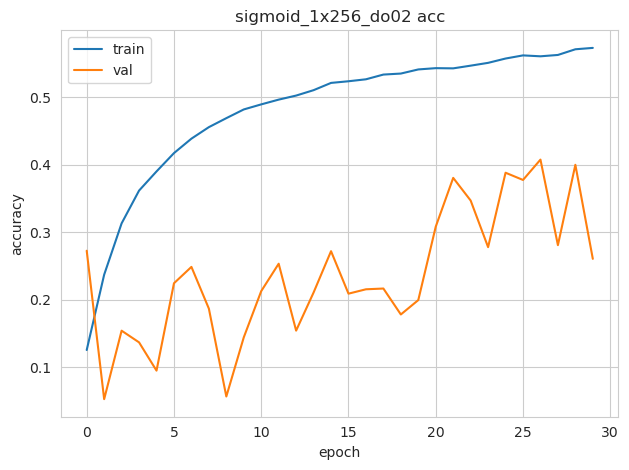

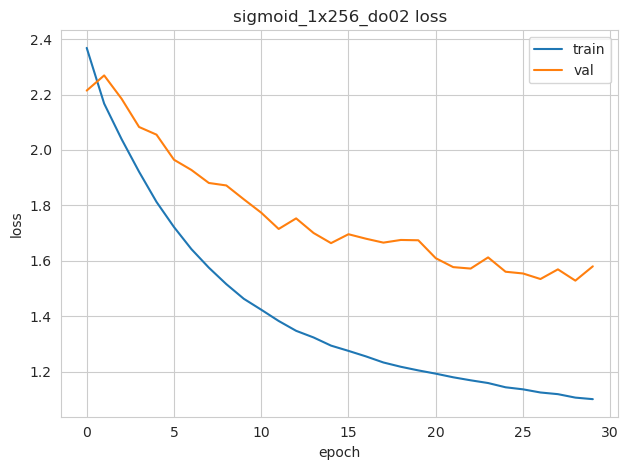

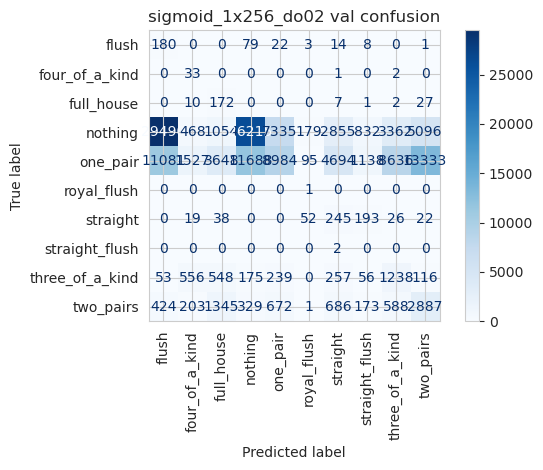

[14/14] sigmoid_2x256_do03
Epoch 1/30
20/20 [==============================] - 1s 23ms/step - loss: 2.3841 - accuracy: 0.1079 - val_loss: 2.2166 - val_accuracy: 0.2747
Epoch 2/30
20/20 [==============================] - 1s 34ms/step - loss: 2.2807 - accuracy: 0.1533 - val_loss: 2.2561 - val_accuracy: 0.1083
Epoch 3/30
20/20 [==============================] - 0s 9ms/step - loss: 2.1831 - accuracy: 0.2211 - val_loss: 2.2307 - val_accuracy: 0.1821
Epoch 4/30
20/20 [==============================] - 0s 8ms/step - loss: 2.0530 - accuracy: 0.2680 - val_loss: 2.2201 - val_accuracy: 0.0135
Epoch 5/30
20/20 [==============================] - 0s 8ms/step - loss: 1.9218 - accuracy: 0.3167 - val_loss: 2.1156 - val_accuracy: 0.0227
Epoch 6/30
20/20 [==============================] - 0s 10ms/step - loss: 1.7962 - accuracy: 0.3570 - val_loss: 1.9931 - val_accuracy: 0.2106
Epoch 7/30
20/20 [==============================] - 0s 9ms/step - loss: 1.6871 - accuracy: 0.3917 - val_loss: 1.8695 - val_accurac

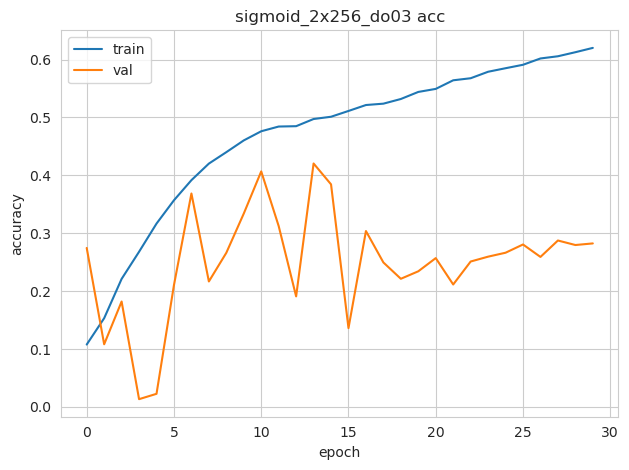

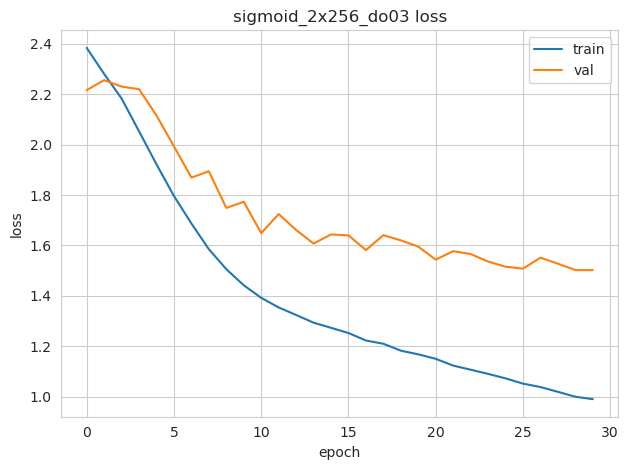

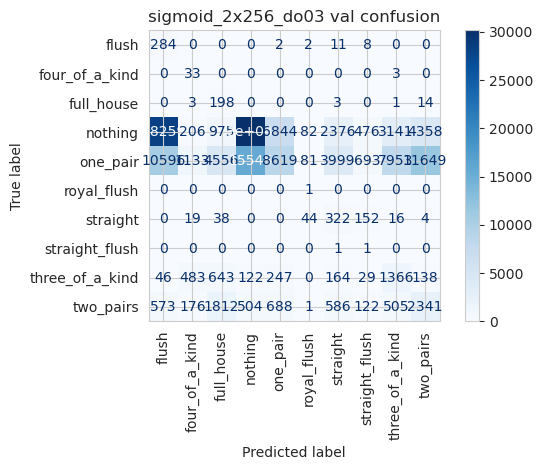

best by macro f1 relu_3x256_do03 0.8806008111090577


In [6]:
best_name = None
best_metric = -1.0
results = []
histories = {}          # store curves for combined plots
confusions = {}         # store cm arrays for later display

EPOCHS = 30

for i, cfg in enumerate(configs, 1):
    print(f'[{i}/{len(configs)}] {cfg["name"]}')
    model = build_model(X_train.shape[1], cfg, num_classes)
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )

    histories[cfg['name']] = {
        'act': cfg['act'],
        'val_accuracy': hist.history.get('val_accuracy', []),
        'val_loss': hist.history.get('val_loss', []),
        'train_accuracy': hist.history.get('accuracy', []),
        'train_loss': hist.history.get('loss', [])
    }

    # per run plots show and save
    acc_path  = f"../artifacts/experiments/{cfg['name']}_acc.png"
    loss_path = f"../artifacts/experiments/{cfg['name']}_loss.png"
    plt.figure(); plt.plot(hist.history['accuracy']); plt.plot(hist.history['val_accuracy']); plt.legend(['train','val']); plt.title(cfg['name']+' acc'); plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.tight_layout(); plt.savefig(acc_path, dpi=150); plt.show()
    plt.figure(); plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']); plt.legend(['train','val']); plt.title(cfg['name']+' loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.tight_layout(); plt.savefig(loss_path, dpi=150); plt.show()

    # val metrics
    yv_pred = model.predict(X_val, batch_size=4096, verbose=0).argmax(1)
    macro_f1 = f1_score(y_val, yv_pred, average='macro')
    val_acc  = float(np.mean(yv_pred == y_val))

    # confusion matrix save and keep for end
    cm = confusion_matrix(y_val, yv_pred)
    confusions[cfg['name']] = cm
    disp = ConfusionMatrixDisplay(cm, display_labels=meta['label_classes'])
    disp.plot(xticks_rotation=90, cmap='Blues')
    plt.title(cfg['name']+' val confusion')
    plt.tight_layout()
    plt.savefig(f"../artifacts/experiments/{cfg['name']}_val_confusion.png", dpi=150)
    plt.show()

    # classification report
    rep = classification_report(y_val, yv_pred, target_names=meta['label_classes'])
    with open(f"../artifacts/experiments/{cfg['name']}_val_report.txt",'w') as f: f.write(rep)

    results.append({'name':cfg['name'],'layers':cfg['layers'],'act':cfg['act'],'dropout':cfg['dropout'],'val_acc':val_acc,'macro_f1':float(macro_f1)})

    if macro_f1 > best_metric:
        best_metric = macro_f1
        best_name = cfg['name']
        model.save('../artifacts/best_so_far.keras')
        with open('../artifacts/best_so_far_name.txt','w') as f: f.write(best_name)

# save summary json
with open('../artifacts/experiments/results.json','w') as f:
    json.dump(results, f, indent=2)

print('best by macro f1', best_name, best_metric)


## Combined plots per activation
show and save combined validation curves per activation group

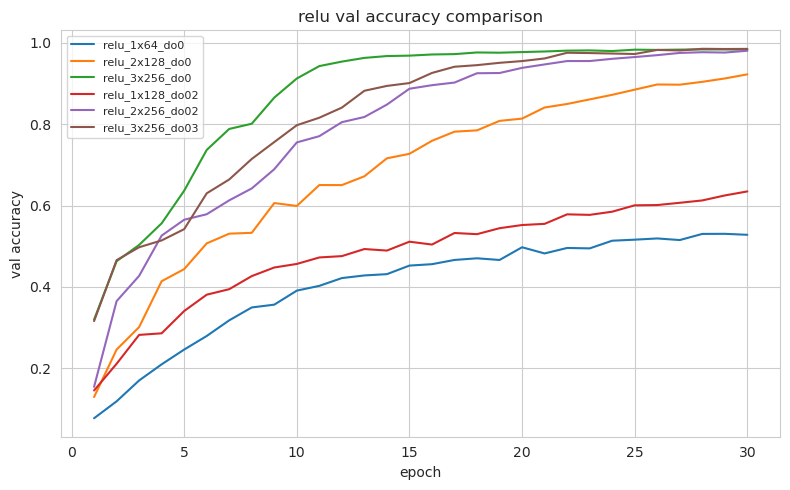

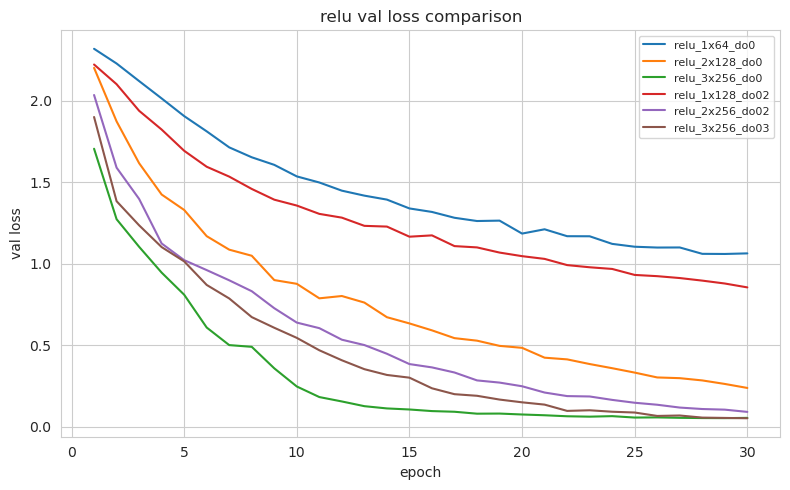

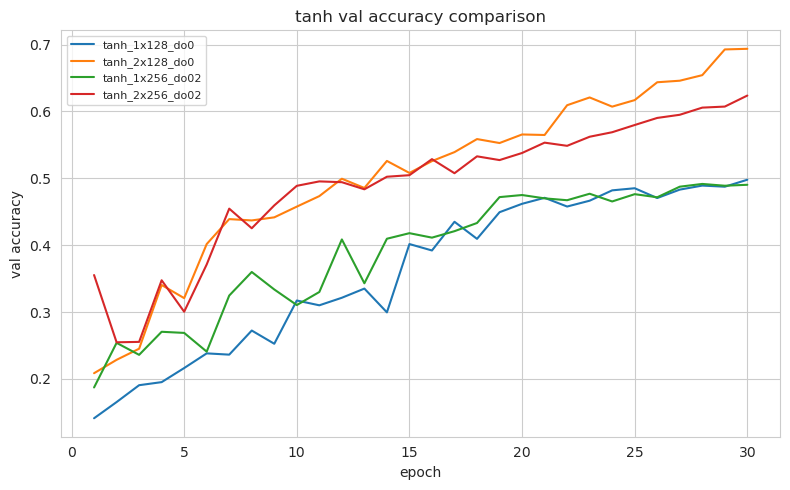

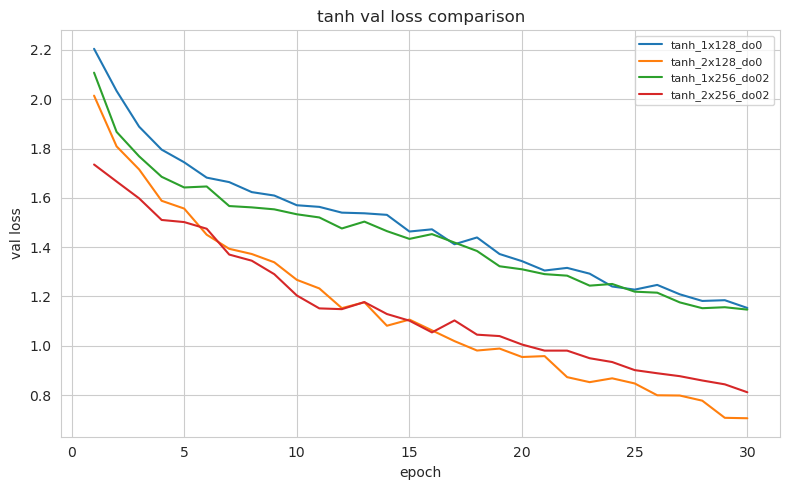

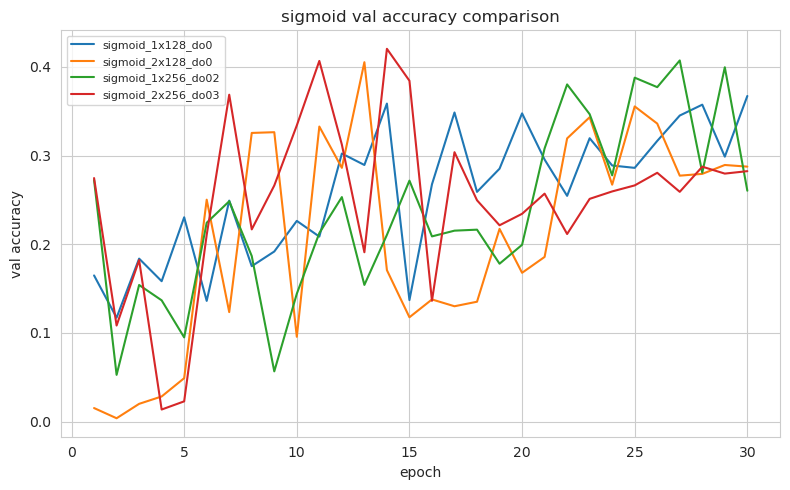

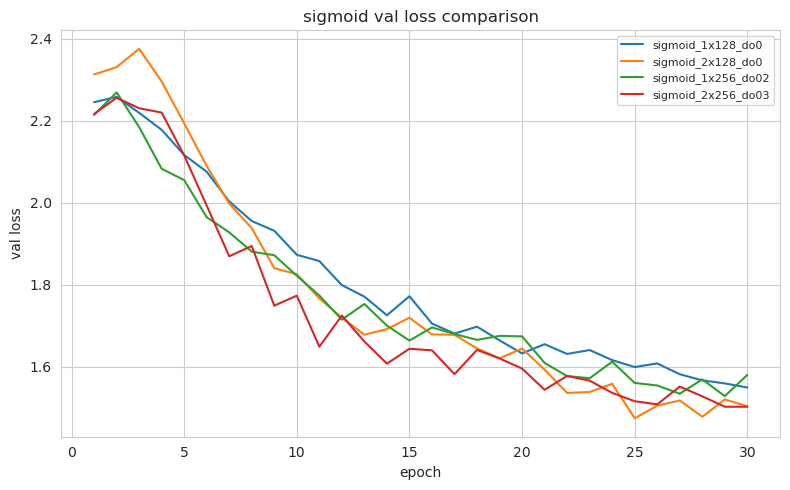

In [7]:
# group names by activation
by_act = {}
for name, h in histories.items():
    act = h['act']
    by_act.setdefault(act, []).append(name)

# make combined plots for each activation
for act, names in by_act.items():
    # val accuracy
    plt.figure(figsize=(8,5))
    for name in names:
        vals = histories[name]['val_accuracy']
        plt.plot(range(1, len(vals)+1), vals, label=name)
    plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title(f'{act} val accuracy comparison'); plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../artifacts/experiments/combined_val_accuracy_{act}.png', dpi=150)
    plt.show()

    # val loss
    plt.figure(figsize=(8,5))
    for name in names:
        vals = histories[name]['val_loss']
        plt.plot(range(1, len(vals)+1), vals, label=name)
    plt.xlabel('epoch'); plt.ylabel('val loss'); plt.title(f'{act} val loss comparison'); plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../artifacts/experiments/combined_val_loss_{act}.png', dpi=150)
    plt.show()


## Overall combined plots
compare top models by macro f1

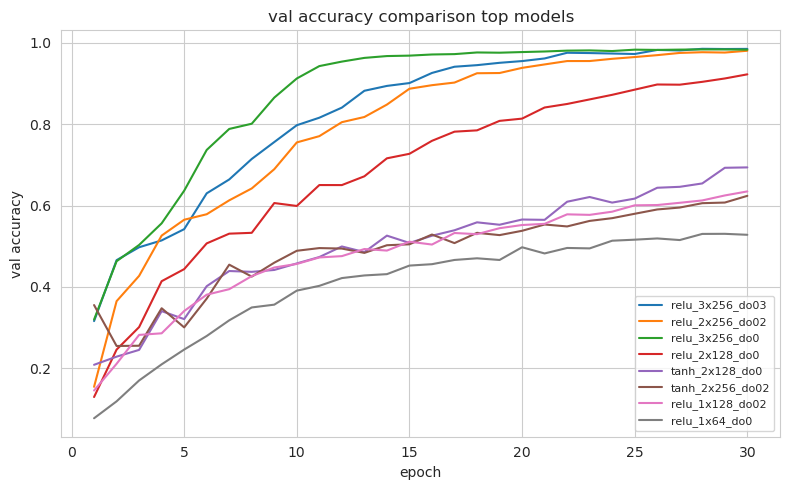

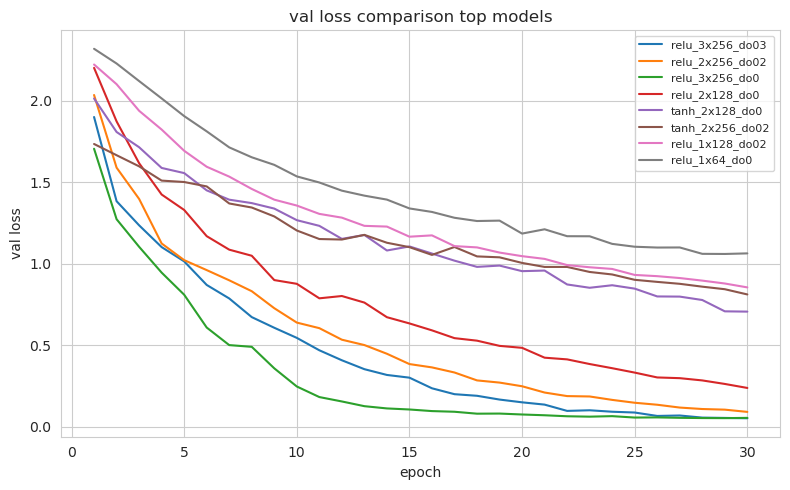

In [8]:
names_sorted = [r['name'] for r in sorted(results, key=lambda x: x['macro_f1'], reverse=True)]
top_names = names_sorted[:8]

plt.figure(figsize=(8,5))
for name in top_names:
    vals = histories[name]['val_accuracy']
    plt.plot(range(1, len(vals)+1), vals, label=name)
plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title('val accuracy comparison top models'); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../artifacts/experiments/combined_val_accuracy_top.png', dpi=150)
plt.show()

plt.figure(figsize=(8,5))
for name in top_names:
    vals = histories[name]['val_loss']
    plt.plot(range(1, len(vals)+1), vals, label=name)
plt.xlabel('epoch'); plt.ylabel('val loss'); plt.title('val loss comparison top models'); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../artifacts/experiments/combined_val_loss_top.png', dpi=150)
plt.show()


## Visualize results json
show bar charts of val accuracy and macro f1 sorted by macro f1

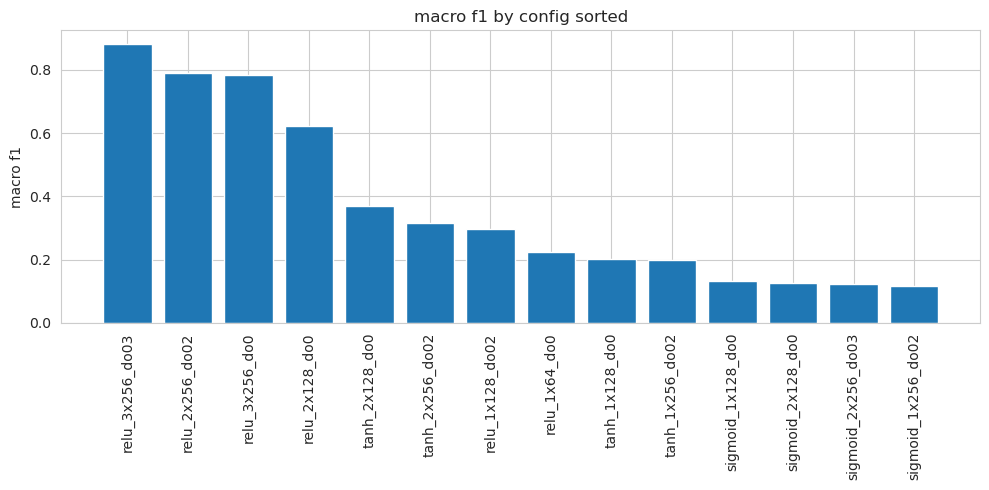

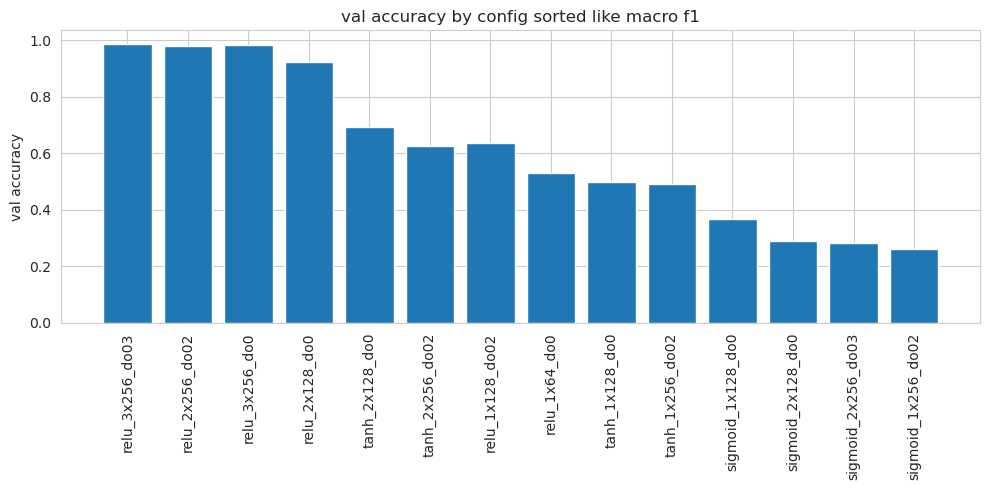

In [9]:
# ensure results is loaded if this cell runs alone
if 'results' not in globals():
    with open('../artifacts/experiments/results.json') as f:
        results = json.load(f)

# sort by macro f1
results_sorted = sorted(results, key=lambda x: x['macro_f1'], reverse=True)
names = [r['name'] for r in results_sorted]
val_accs = [r['val_acc'] for r in results_sorted]
macro_f1s = [r['macro_f1'] for r in results_sorted]

# macro f1 bar
plt.figure(figsize=(10,5))
plt.bar(range(len(names)), macro_f1s)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('macro f1'); plt.title('macro f1 by config sorted')
plt.tight_layout()
plt.savefig('../artifacts/experiments/results_macro_f1.png', dpi=150)
plt.show()

# val acc bar
plt.figure(figsize=(10,5))
plt.bar(range(len(names)), val_accs)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('val accuracy'); plt.title('val accuracy by config sorted like macro f1')
plt.tight_layout()
plt.savefig('../artifacts/experiments/results_val_acc.png', dpi=150)
plt.show()
